## Setup

### Import dependecies

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
from pathlib import Path


### Check foe gpu

In [3]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

## Collect the data

In [4]:
tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_root + filename,
                                   cache_dir=".",
                                   extract=True)

1065301781/1065301781 ━━━━━━━━━━━━━━━━━━━━ 33s 0us/step


In [5]:
quickdraw_dir = Path(filepath).parent # get the directory
# for all the files in quickdraw_dir matching the pattern 'training.tfrecord-*',
# convert their paths to strings, and sort the resulting list alphabetically
train_files = sorted([str(path) for path in quickdraw_dir.glob('training.tfrecord-*')])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [6]:
train_files

['datasets/training.tfrecord-00000-of-00010',
 'datasets/training.tfrecord-00001-of-00010',
 'datasets/training.tfrecord-00002-of-00010',
 'datasets/training.tfrecord-00003-of-00010',
 'datasets/training.tfrecord-00004-of-00010',
 'datasets/training.tfrecord-00005-of-00010',
 'datasets/training.tfrecord-00006-of-00010',
 'datasets/training.tfrecord-00007-of-00010',
 'datasets/training.tfrecord-00008-of-00010',
 'datasets/training.tfrecord-00009-of-00010']

In [7]:
eval_files

['datasets/eval.tfrecord-00000-of-00010',
 'datasets/eval.tfrecord-00001-of-00010',
 'datasets/eval.tfrecord-00002-of-00010',
 'datasets/eval.tfrecord-00003-of-00010',
 'datasets/eval.tfrecord-00004-of-00010',
 'datasets/eval.tfrecord-00005-of-00010',
 'datasets/eval.tfrecord-00006-of-00010',
 'datasets/eval.tfrecord-00007-of-00010',
 'datasets/eval.tfrecord-00008-of-00010',
 'datasets/eval.tfrecord-00009-of-00010']

In [8]:
# Open file names "eval.tfrecord.classes" in quickdraw_dir and concatenate the dir with the file name using / from pathlib
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines() # reads all the lines from the opened file and store them in a list
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [9]:
assert train_classes == test_classes # ensure that the two lists are equal otherwise return assertion error
class_names = [name.strip().lower() for name in train_classes]

In [10]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [11]:
def parse(data_batch):
  """
  - Parse a batch of serialized TFRecord data.
  - Convert and reshape the data into a usable format for training or evaluating a machine learning model.
  """
  # Define the structure and types of features in the input data
  feature_descriptions = {
      "ink": tf.io.VarLenFeature(dtype=tf.float32), # sparse float array for ink strokes
      "shape": tf.io.FixedLenFeature([2], dtype=tf.int64), # fixed-length [2] int64 for shape of sketch
      "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64), # fixed-length [1] int64 for class
  }
  # Parse the input batch according to the feature descriptions
  examples = tf.io.parse_example(data_batch, feature_descriptions)
  # Convert the sparse ink feature into dense tensore
  flat_sketches = tf.sparse.to_dense(examples["ink"]) # because operations like reshaping require dense tensors
  # Reshape the dense sketches into [batch_size, sequence_length, 3]
  sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
  # Extract the length of each sketch from the "shape" feature
  lengths = examples["shape"][:, 0]
  # Extract the class labels (indexes) from the "class_index" feature
  labels = examples["class_index"][:, 0]
  return sketches, lengths, labels

In [12]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):

    """
    Reads data from TFRecord files in parallel.
    (Optionally) caches and shuffles the data for better performance and randomness.
    Batches the data into manageable chunks for training.
    Parses the data into usable formats using the parse function.
    Prefetches data to avoid bottlenecks during model training.
    """
    # Create a dataset from the TFRecord files and enable parallel reading
    dataset = tf.data.TFRecordDataset(filepaths,
                                       num_parallel_reads=n_read_threads)
    # Optionally cache the dataset for faster subsequent accesses
    if cache:
        dataset = dataset.cache()
    # Optionally shuffle the dataset using the specified buffer size
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    # Batch the dataset into batches of size 'batch_size'
    dataset = dataset.batch(batch_size)
    # Apply the 'parse' function to each batch in parallel using multiple threads
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    # Prefetch 1 batch of data to ensure seamless data loading during training
    return dataset.prefetch(1)

### Create train, validation and test sets

In [13]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000) # create training set, shuffle it to ensure good level of randomness
valid_set = quickdraw_dataset(eval_files[:5]) # Create a validation dataset from the first 5 evaluation files
test_set = quickdraw_dataset(eval_files[5:])# Create a test dataset from the remaining evaluation files (starting from the 6th file)

### Verifies the shapes and contents of sketches, lengths, and labels.

In [14]:
for sketches, lengths, labels in train_set.take(1): # verify for ine batch of data
    # Print the sketches tensor to understand its structure and contents
    print("sketches =", sketches)
    # Print the lengths tensor to verify the number of points in each sketch
    print("lengths =", lengths)
    # Print the labels tensor to check the class labels for each sketch in the batch
    print("labels =", labels)

sketches = tf.Tensor(
[[[ 0.01568628  0.13888893  0.        ]
  [ 0.09411765  0.48809522  0.        ]
  [ 0.04705883  0.00396824  0.        ]
  ...
  [ 0.04705882 -0.01984127  0.        ]
  [ 0.01960784  0.03968254  0.        ]
  [-0.07058823  0.0515873   1.        ]]

 [[ 0.          0.7764706   0.        ]
  [ 0.30708662  0.          0.        ]
  [ 0.18503937 -0.07058823  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.06274509  0.05298012  0.        ]
  [-0.48627454  0.2847682   0.        ]
  [-0.04313726  0.04635763  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.10096154  0.25882354  0.        ]
  [ 0.          0.1490196   0.        ]
  [-0.1298077   0.3137255   0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

###  Visualizing sketches from the dataset

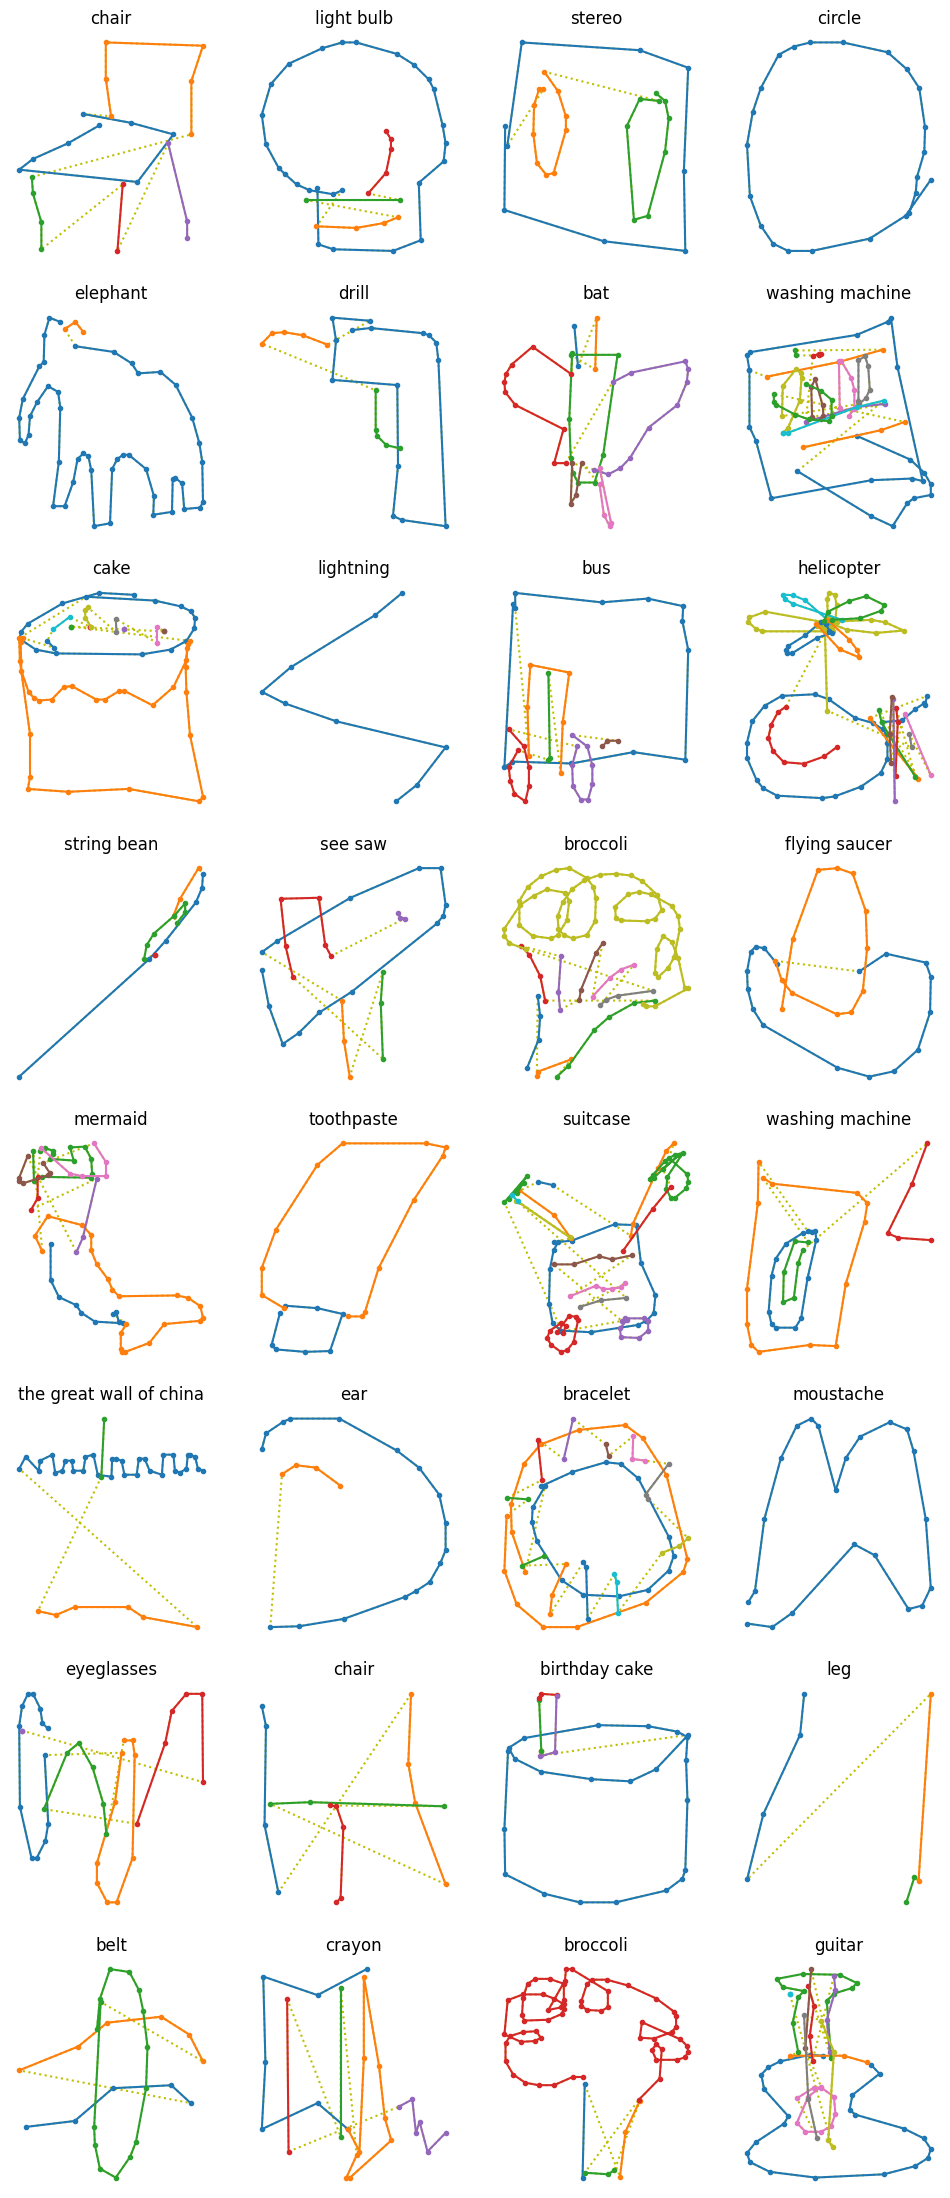

In [15]:
def draw_sketch(sketch, label=None):
  """
  Visualize single sketch with optional labeling
  """
  origin = np.array([[0., 0., 0.]])
  sketch = np.r_[origin, sketch]
  stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
  coordinates = sketch[:, :2].cumsum(axis=0)
  strokes = np.split(coordinates, stroke_end_indices + 1)
  title = class_names[label.numpy()] if label is not None else "Try to guess"
  plt.title(title)
  plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
  for stroke in strokes:
      plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
  plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

### Most sketches are composed of less than 100 points:

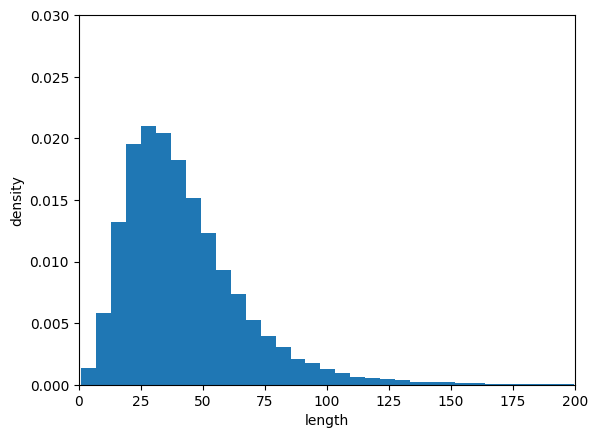

In [16]:
# Collect lengths from the first 1000 batches of the training set into a single numpy array
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [17]:
# crop excessively long sketches in the dataset to a specified maximum length.
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

## Create the network and fitting it to the data (training)

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
 107813/Unknown 784s 7ms/step - accuracy: 0.0808 - loss: 4.8409 - sparse_top_k_categorical_accuracy: 0.2064

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


107813/107813 ━━━━━━━━━━━━━━━━━━━━ 801s 7ms/step - accuracy: 0.0808 - loss: 4.8409 - sparse_top_k_categorical_accuracy: 0.2064 - val_accuracy: 0.3137 - val_loss: 3.0642 - val_sparse_top_k_categorical_accuracy: 0.5982
Epoch 2/2
107813/107813 ━━━━━━━━━━━━━━━━━━━━ 817s 8ms/step - accuracy: 0.3527 - loss: 2.8491 - sparse_top_k_categorical_accuracy: 0.6418 - val_accuracy: 0.4269 - val_loss: 2.4546 - val_sparse_top_k_categorical_accuracy: 0.7155


In [19]:
# preparing test data and making predictions
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

5392/5392 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step


In [20]:
np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.6029804

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


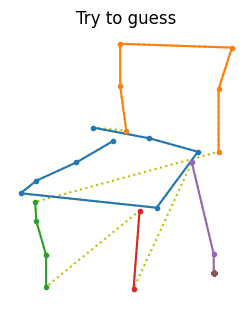

Top-5 predictions:
  1. chair 71.374%
  2. yoga 4.868%
  3. bed 2.669%
  4. church 2.211%
  5. table 1.348%
Answer: chair


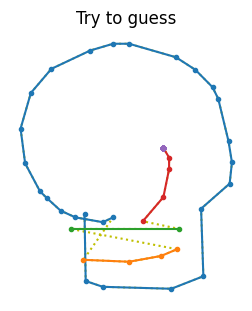

Top-5 predictions:
  1. light bulb 76.975%
  2. leaf 4.186%
  3. pond 3.800%
  4. hot air balloon 3.018%
  5. frying pan 0.790%
Answer: light bulb


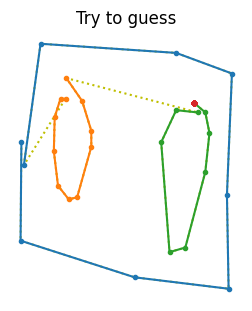

Top-5 predictions:
  1. camera 34.879%
  2. stereo 23.740%
  3. radio 12.345%
  4. sleeping bag 5.295%
  5. power outlet 2.690%
Answer: stereo


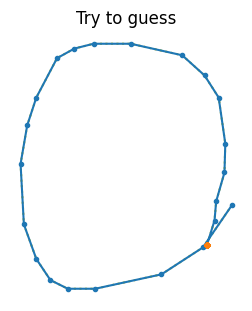

Top-5 predictions:
  1. circle 36.925%
  2. potato 16.684%
  3. pond 7.599%
  4. bread 6.543%
  5. necklace 4.733%
Answer: circle


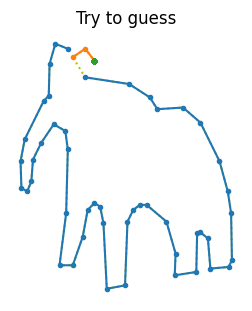

Top-5 predictions:
  1. camel 52.006%
  2. giraffe 10.528%
  3. horse 9.437%
  4. elephant 6.640%
  5. rhinoceros 3.919%
Answer: elephant


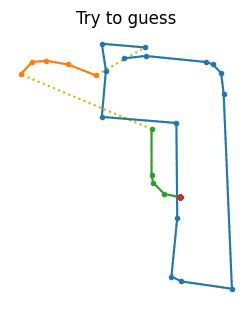

Top-5 predictions:
  1. drill 66.640%
  2. screwdriver 3.425%
  3. spoon 2.828%
  4. key 1.571%
  5. rifle 1.510%
Answer: drill


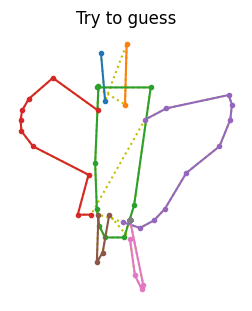

Top-5 predictions:
  1. bat 16.663%
  2. mosquito 9.413%
  3. dog 5.869%
  4. dragon 5.458%
  5. ceiling fan 4.810%
Answer: bat


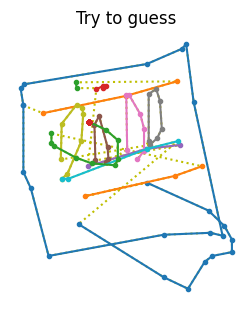

Top-5 predictions:
  1. stove 14.141%
  2. toaster 13.875%
  3. hospital 12.919%
  4. lighter 6.989%
  5. sink 4.694%
Answer: washing machine


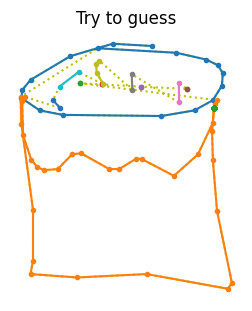

Top-5 predictions:
  1. hot tub 9.865%
  2. cake 9.747%
  3. strawberry 9.076%
  4. coffee cup 9.004%
  5. paint can 6.976%
Answer: cake


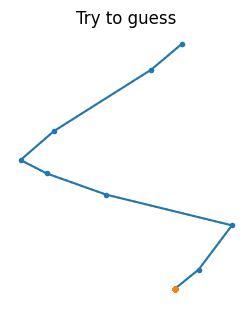

Top-5 predictions:
  1. knee 27.265%
  2. zigzag 24.517%
  3. lightning 14.491%
  4. squiggle 11.997%
  5. nose 5.849%
Answer: lightning


In [32]:
#visualizes the top-5 predictions for a set of sketches along with their corresponding probabilities
n_new = 10 # Defines the number of sketches to evaluate and display predictions for
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5) # Extracts the top-5 predictions for each sketch
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba)) # Prints the rank (1 through 5), class name, and probability percentage for the prediction.
    print("Answer: {}".format(class_names[labels[index].numpy()])) # Prints the actual label (ground truth) of the sketch. 

## Save the model

In [28]:
model.save("my_sketchrnn.h5")